# 2D IR Spectral Diffusion Analysis Script v.0 - Guide

#### by Sebastian Gorgon [(sebgorgon.github.io)](https://sebgorgon.github.io) of ULTRA, Central Laser Facility

This is a walkthrough aiming to help in using the program for conducting actual fittings.


To utilise, copy the contents of the first cell into a fresh Jupyter notebook and call the functions as outlined in the [User guide](#User-guide) below.

In summary, each population time dataset is read, cropped to the selected region, and either a single 2D Gaussian fitted to the positive or negative peak, or a linear combination of two 2D Gaussians with the same spreads and angles fitted to the peak pair at once.

In [1]:
### SET UP OF ENVIRONMENT ###

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize as opt
import math
import os



### SET UP OF GENERAL DATA PRE-PROCESSING ###

def df_separate(df):
    
    """Separates dataframe into 1D lists of x and y values, and a 2D matrix of z values"""

    x1d = np.array(df[df.columns[0]])[1:]  
    df = df.drop(df.columns[0], axis=1)
    y1d = np.array(df)[0,:]  
    z2d = np.array(df)[1:,:]

    return x1d, y1d, z2d

def df_to_xyz(df):
    
    """Converts dataframe to 1D arrays of XYZ with one-to-one correspondence - for fitting data"""
    
    df = np.array(df)
    X, Y, Z = [], [], []
    for i, y in enumerate(df[0][1:], 1):
        for z in df[1:]:
            X.append(z[0])
            Y.append(y)
            Z.append(z[i])
    return np.vstack((X,Y,Z))

def df_join(x, y, z):    
    
    """Creates dataframe from 1D lists of x and y values, and a 2D matrix of z values"""
    
    combmap = np.insert(z, 0, x, axis=1) 
    y = np.insert(y, 0, 0)
    combmap = np.insert(combmap, 0, y, axis=0)
    return pd.DataFrame(combmap)
    
def val_to_index(val, array):
    
    """Returns index of number inside the array that is closest to set value"""
    
    return np.abs(array-val).argmin()   

def crop_df(df, xrange, yrange):

    """Crops the dataset to selected region"""
    
    x1d, y1d, z2d = df_separate(df)
    x1d = x1d[:int(len(x1d)/2)]
    xlimits = (val_to_index(xrange[0], x1d), val_to_index(xrange[1], x1d))
    ylimits = (val_to_index(yrange[0], y1d), val_to_index(yrange[1], y1d))

    x1d = x1d[xlimits[0]:xlimits[1]+1]    
    y1d = y1d[ylimits[0]:ylimits[1]+1]
    z2d = z2d[xlimits[0]:xlimits[1]+1,ylimits[0]:ylimits[1]+1]
    return df_join(x1d, y1d, z2d)

def contour_plot(df, zlim=50):
    
    """Generates a 2D plot of a dataset"""
    
    x1d, y1d, z2d = df_separate(df)
    plt.contourf(x1d, y1d, z2d.transpose(), zlim, cmap='coolwarm')
    plt.colorbar()
    plt.xlabel('Probe / cm-1')
    plt.ylabel('Pump / cm-1')
    return 

def display_dataset(direct):
    
    """Displays first frame of dataset so that x and y limits can be set"""
    
    paths = []
    for filename in os.listdir(direct):
        if filename.endswith("2DIR.csv"):
             paths.append(str(os.path.join(direct, filename)))
    frame = paths[0] 
    dataset = pd.read_csv(frame, header=None, delimiter='\t') 
    return contour_plot(np.abs(dataset))



### DEFINES 2 TYPES OF 2D GAUSSIAN FUNCTIONS ###

def uni_gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6]
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    xo, yo = float(xo), float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)

    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def bi_gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude1, amplitude2, xo1, xo2, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], param[8]    
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    g = offset + amplitude1*np.exp( - (a*((x-xo1)**2) + 2*b*(x-xo1)*(y-yo) + c*((y-yo)**2))) \
    + amplitude2*np.exp( - (a*((x-xo2)**2) + 2*b*(x-xo2)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()



### SET UP OF FITING ROUTINE ###

def fit_prepare(peakselect, data, p0):

    """Prepares data for fitting given the chosen parameters"""
    
    if peakselect == 1:
        zfin = [0 if j < 0 else j for j in data]
        zfin = np.array(zfin)
        p0 = np.delete(p0, [1,3])
        func = uni_gauss
        
    elif peakselect == -1:
        zfin = [0 if j > 0 else j for j in data]
        zfin = - np.array(zfin)         
        p0 = np.delete(p0, [1,2])
        func = uni_gauss

    elif peakselect == 0:
        zfin = np.abs(data)
        func = bi_gauss
        
    return zfin, p0, func

def fit_calc(popt, pcov, time, func):
    
    """Calculates frame fit results from optimized parameters"""
    
    std = np.sqrt(np.diag(pcov))
    
    if func is uni_gauss:
        popt = np.insert(popt, [1,2], [popt[0], popt[1]])
        std = np.insert(std, [1,2], [std[0], std[1]])

    sx, sy, ex, ey = abs(popt[5]), abs(popt[6]) ,std[5],std[6]
    if sx < sy:
        sx, sy, ex, ey = sy, sx, ey, ex
    
    elipt = abs((sy)**2 - (sx)**2)/((sx)**2 + (sy)**2)
    elipterr = ((((2*sx-sy**2)/(2*sx+sy**2))*ex)**2+(((sx**2-2*sy)/(sx**2+2*sy))*ey)**2)**0.5

    theta = popt[7] - (popt[7] // np.pi) * np.pi
    if theta > 0.5 * np.pi:
        theta = np.pi - theta
    if theta < 0.25 * np.pi:
        theta = 0.5 * np.pi - theta
    thetaerr = std[7]                     

    igrad = 1 / math.tan(theta)
    igraderr = ((np.cos(theta)) ** 0.5) * thetaerr                     

    arrres = (time, popt[0], popt[1], popt[2], popt[3], popt[4], sx, ex, sy, ey, elipt,\
              elipterr, theta, thetaerr, igrad, igraderr)
    cols = ['time','Ampl_1','Ampl_2','x0_1','x0_2','y_0', 'sigma_x', 'sigma_x_err','sigma_y',\
            'sigma_y_err', 'elipt','elipt_err', 'theta', 'theta_err', 'igrad', 'igrad_err']

    dfres = pd.DataFrame(columns=cols)
    dfres.loc[0] = np.array(arrres)
    dfres = dfres.set_index('time')
    return dfres

def fit_frame(xyzdat, peakselect, time, p0):

    """Orders processing of a single timedelay frame."""
    
    try:
        xy = np.append(xyzdat[0], xyzdat[1])
        zfin, p0, func = fit_prepare(peakselect, xyzdat[2], p0)
        popt, pcov = opt.curve_fit(f=func, xdata=xy, ydata=zfin, p0=p0, method='dogbox', maxfev=1000)
        fitraveled = func(xy, popt)

        resrow = fit_calc(popt, pcov, time, func)
        
        diff = zfin - fitraveled
        qfit = sum((abs(diff))/popt[0])                          ## FIX QFIT PARAMETER
        
        datforfig = xyzdat, fitraveled, diff
        
    except RuntimeError:
        print("Error - curve_fit failed")

    return datforfig, resrow

def plot_frame(df, datforfig, frame):

    """Generates the figure"""
    
    xyzdat, fitraveled, diff = datforfig
    extx = (np.min(xyzdat[0]), np.max(xyzdat[0]), np.min(xyzdat[1]), np.max(xyzdat[1]))
    
    fig = plt.figure(figsize=(8,3))

    plt.subplot(1, 2, 1)

    contour_plot(df) 
    plt.tricontour(xyzdat[0], xyzdat[1], fitraveled, 5, extent=extx, linewidths=1, colors='k')
    plt.title('Fit')
    
    x1d, y1d, z2draw = df_separate(df)
    z2d = np.reshape(diff, (len(y1d), len(x1d)))
    diffdf = df_join(x1d, y1d, z2d.transpose())

    plt.subplot(1, 2, 2)
    contour_plot(diffdf)
    plt.title('Difference')
    
    plt.subplots_adjust(top=0.8, bottom=0.196, left=0.138, right=0.898, hspace=0.2, wspace=0.55)
    fig.patch.set_facecolor('w')
    plt.suptitle(str(frame), verticalalignment = 'top')
    plt.show()
    return fig

def fit_dataset(direct, peakselect, p0, xrange, yrange, savedata=False, oneframe=False, showfig=False):
    
    """Fits the entire dataset"""
    
    paths = []
    combres = pd.DataFrame()

    for filename in os.listdir(direct):
        if filename.endswith("2DIR.csv"):
            paths.append(str(os.path.join(direct, filename)))

    if oneframe is True:
        paths = paths[0:1]
            
    for i in range(len(paths)):
        frame = paths[i]
        time = float(frame[(frame.find('_')+1):frame.find('ps')])
                                    
        dffr = pd.read_csv(frame, header=None, delimiter='\t')
        dfframe = crop_df(dffr, xrange, yrange) 

        xyzdat = df_to_xyz(dfframe)
        datforfig, resrow = fit_frame(xyzdat, peakselect, time, p0)
        
        combres = pd.concat([combres, resrow])                                
        combres = combres.sort_index(axis=0)
        
        if showfig is True:  
            fig = plot_frame(dfframe, datforfig, frame) 
            print('-----------------------------')

        if savedata is True:
            fig.savefig((direct + '/' + str(time) + '.png'), dpi=200, facecolor='w')
            combres.to_csv((direct + '/' + 'fit_results.csv'), sep=',')
           
    return combres

## User guide

The script has two user callable functions: `display_dataset` and `fit_dataset`.

Initially, call `display_dataset` to enable region and initial parameter selection.
Subsequently, use `fit_dataset` as described below to conduct analyses. 

### Preparing the dataset

The `target` string specifies the directory where the 2D IR specral files are located. These must have titles saved in the LifeTIME format (name_time_2DIR.csv).

Note that values defined in previous cells are passed down to subsequent ones if not overwritten.

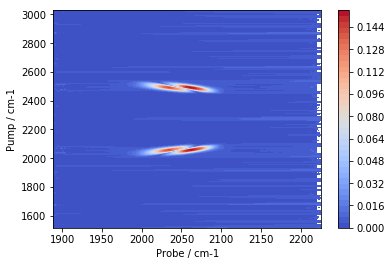

In [2]:
target = 'C:/PYTHONALL/023s'

display_dataset(target)

Initial fitting parameters must be specified manually via the `p0` array, which contains the following values: (`amplitude pos` ,  `amplitude neg` (absolute value),  `x-centre pos` ,  `x-centre neg` ,  `y-centre` ,  `x-sigma` ,  `y-sigma` ,  `theta` ,  `z-offset`).

To enable fitting of crowded spectra and maximise the fitting speed, the fitting area should be as small as possible. This can be controlled via the `xrange` and `yrange` tuples.

In [3]:
p0 = (0.20, 0.15, 2039, 2060, 2065, 20, 5, 0, 0)   
xrange = (1960, 2120)
yrange = (2000, 2110)

### Peak selection

Depending on the value of the `peakselect` constant, the program performs a fit of either a linear combination of convolved two 2D Gaussians to the peak pair (`peakselect = 0`), or of a single 2D Gaussian to the positive (`peakselect = 1`) or negative (`peakselect = -1`) peak.

The `oneframe` boolean specifies whether to display just the first frame in the dataset (`oneframe = True`) for parameter optimisation, or run through the entire dataset (`oneframe = False`).

To save the figures and results table in the directory of raw spectra, select `savedata = True`.

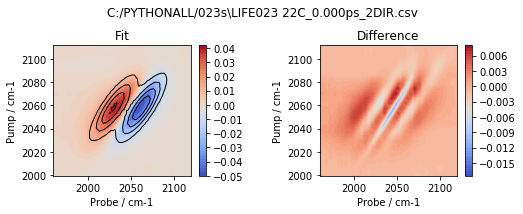

-----------------------------


,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,
0.0,0.040571,0.048358,2029.298044,2062.359785,2057.952602,21.840431,0.168872,6.75089,0.047405,0.825578,0.044938,0.795086,0.003749,0.98081,0.003137


In [4]:
peakselect = 0 

fit_dataset(target, peakselect, p0, xrange, yrange, savedata=False, oneframe=True, showfig=True)

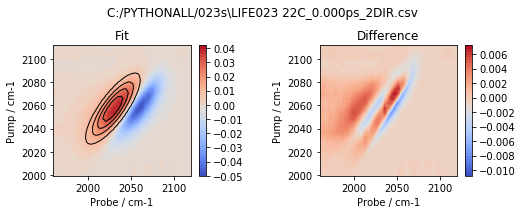

-----------------------------


,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,
0.0,0.039652,0.039652,2028.945834,2028.945834,2057.350496,23.125424,0.194908,7.498827,0.063256,0.80971,0.062746,0.811771,0.004168,0.948598,0.003458


In [5]:
peakselect = 1

fit_dataset(target, peakselect, p0, xrange, yrange, savedata=False, oneframe=True, showfig=True)

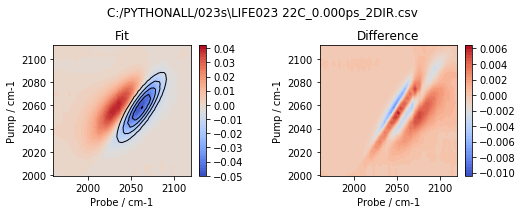

-----------------------------


,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,
0.0,0.050316,0.050316,2062.474689,2062.474689,2058.359113,22.092974,0.12982,6.753063,0.039708,0.829104,0.037626,0.814333,0.002725,0.943742,0.002258


In [6]:
peakselect = -1

fit_dataset(target, peakselect, p0, xrange, yrange, savedata=False, oneframe=True, showfig=True)

### Run through entire dataset

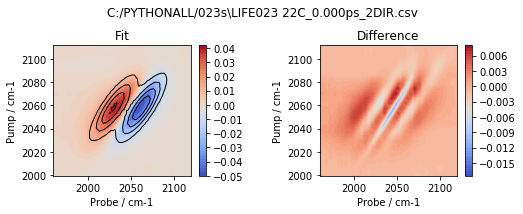

-----------------------------


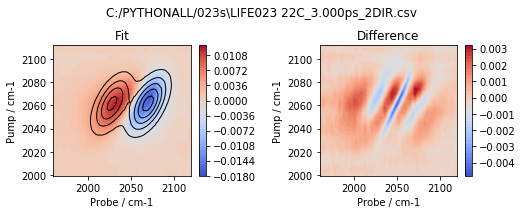

-----------------------------


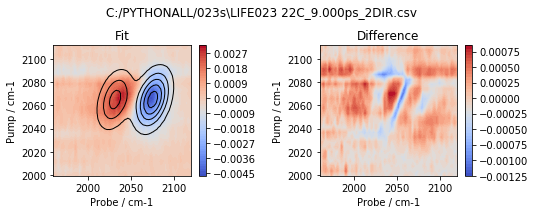

-----------------------------


,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,
0.0,0.040571,0.048358,2029.298044,2062.359785,2057.952602,21.840431,0.168872,6.750890,0.047405,0.825578,0.044938,0.795086,0.003749,0.980810,0.003137
3.0,0.012583,0.016153,2027.866171,2070.093651,2061.749037,18.327936,0.159910,9.632971,0.077898,0.567098,0.098143,0.857025,0.008398,0.866108,0.006795
9.0,0.002517,0.004243,2031.465838,2075.337816,2065.185257,16.244295,0.183789,10.551746,0.109634,0.406533,0.137387,1.046481,0.017115,0.578306,0.012110


In [7]:
peakselect = 0  
oneframe = False
savedata = True 

fit_dataset(target, peakselect, p0, xrange, yrange, savedata, oneframe, showfig=True)